Katarzyna Wilk, Jakub Ziomek, Filip Tomczyk

#Załączanie google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#PIP

Instalacja pip z gymnasium i stable_baselines3

In [ ]:
%%capture
!pip install gymnasium
!pip install "stable_baselines3[extra]>=2.0.0a9"

#Importy

In [ ]:
import os
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
from typing import NamedTuple

from stable_baselines3 import HerReplayBuffer, SAC
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

/usr/local/lib/python3.10/dist-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


#Klasy

## Klasa ``SaveAllTrainingStepsCallback``
Wywołanie zwrotne do zapisania modelu (sprawdzanie odbywa się na każdym kroku)
na podstawie nagrody za trening (w praktyce zalecamy użycie ``EvalCallback``).


``log_dir``: (str) Ścieżka do folderu, w którym zostanie zapisany model.
      Musi on zawierać plik utworzony przez wrapper ``Monitor``.

``verbose``: (int) Liczba całkowita wskazująca poziom szczegółowości drukowania informacji podczas wykonywania programu.

## Klasa ``Configure``
Fragment kodu definiuje klasę ``NamedTuple`` o nazwie ``Configure``, która służy do reprezentowania konfiguracji dla określonego zadania lub eksperymentu. ``NamedTuple`` jest podklasą tuple, która umożliwia definiowanie nazwanych pól dla elementów.

``env_id``: Ciąg znaków reprezentujący identyfikator lub nazwę środowiska.

``num_cpu``: Liczba całkowita określająca liczbę procesorów lub rdzeni procesora, które mają zostać użyte.

``n_timesteps``: Liczba całkowita określająca całkowitą liczbę kroków czasowych lub kroków do wykonania podczas szkolenia.

``log_dir``: Ciąg znaków reprezentujący ścieżkę katalogu, w którym zapisywane będą pliki dziennika i wyniki.

``DATA_DIR``: Ciąg znaków reprezentujący ścieżkę katalogu dla dodatkowych danych, jeśli dotyczy.

``dir``: Ciąg znaków reprezentujący określony katalog, którego przeznaczenie nie zostało wyraźnie wymienione we fragmencie kodu.

``verbose``: Liczba zmiennoprzecinkowa lub całkowita wskazująca poziom szczegółowości drukowania informacji podczas wykonywania programu.

``buffer_size``: Liczba całkowita określająca rozmiar bufora używanego w procesie uczenia.

``learning_rate``: Liczba zmiennoprzecinkowa reprezentująca współczynnik uczenia dla algorytmu uczenia.

``gamma``: Liczba zmiennoprzecinkowa reprezentująca współczynnik dyskonta używany w algorytmie uczenia ze wzmocnieniem.

In [ ]:
class SaveAllTrainingStepsCallback(BaseCallback):

    def __init__(self, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.log_dir = log_dir
        self.rewards_file = os.path.join(log_dir, "training_rewards.csv")
        self.step_counter = 0


    def _init_callback(self) -> None:
        # Create folder if needed
        print(self.rewards_file)
        if self.rewards_file is not None:
            os.makedirs(self.log_dir, exist_ok=True)
            with open(self.rewards_file, mode='w') as file:
                writer = csv.writer(file)
                writer.writerow(['Timestep', 'Mean Reward'])

    def _on_step(self) -> bool:
        # Retrieve training reward
        x, y = ts2xy(load_results(self.log_dir), "timesteps")
        if len(x) > 0:
            # Mean training reward over the last 100 episodes
            mean_reward = np.mean(y[-100:])
            if self.verbose > 0:
                print(f"Num timesteps: {self.num_timesteps}")
                print(f"Last mean reward per episode: {mean_reward:.2f}")

            with open(self.rewards_file, mode='a') as file:
                writer = csv.writer(file)
                writer.writerow([self.num_timesteps, mean_reward])

        return True
#####
class Configure(NamedTuple):
    env_id: str
    num_cpu: int
    n_timesteps: int
    log_dir: str
    DATA_DIR: str = ""
    dir: str = "" #TO JEST ZAP
    verbose: float = 1
    buffer_size: int = 256
    learning_rate: float = 1e-3
    gamma: float = 0.95
#####

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Funkcje

In [ ]:
def make_model_and_learn(env_id: str, log_dir: str, num_cpu: int,
                         n_timesteps: int, verbose: float, buffer_size: int,
                         learning_rate: float, gamma: float, num: int, DATA_DIR: str):

    # Create and wrap the environment
    env = gym.make(env_id)
    # Logs will be saved in log_dir/monitor.csv
    print(log_dir)
    env = Monitor(env, log_dir)

    callback = SaveAllTrainingStepsCallback(log_dir=log_dir) #log dir zmieniony


    model = SAC(
        "MultiInputPolicy",
        env,
        replay_buffer_class=HerReplayBuffer,
        replay_buffer_kwargs=dict(
            n_sampled_goal=4,
            goal_selection_strategy="future",
        ),
        verbose=verbose,
        buffer_size=buffer_size,
        learning_rate=learning_rate,
        gamma=gamma,
        batch_size=256,
        policy_kwargs=dict(net_arch=[256, 256, 256]),
        learning_starts=n_timesteps + 1
    )

    model.learn(total_timesteps=n_timesteps, callback=callback)

    # Save the trained agent
    model.save(DATA_DIR+ 'her_sac_highway' + str(num))
    return model


def plot_rews(path):

  mydict = dict()

  for i in range(10):
    timesteps = []
    rewards = []
    var = []
    with open(path + str(i) + "/training_rewards.csv", mode='r') as file:
        reader = csv.reader(file)
        next(reader)  # Skip header row
        for row in reader:
            t = row[0]
            r = row[1]
            timesteps.append(int(t))
            rewards.append(float(r))
            if str(t) in mydict:
              mydict[str(t)].append(float(r))
            else:
              mydict[str(t)] = [float(r)]



    # Calculate standard deviation
    rewards_std = np.std(rewards)

    # Plot the chart
    plt.plot(timesteps, rewards)
    plt.fill_between(timesteps, np.subtract(rewards, rewards_std), np.add(rewards, rewards_std), alpha=0.2)
    plt.xlabel('Timesteps')
    plt.ylabel('Mean Reward')
    plt.title('Training Rewards with Standard Deviation')
    plt.show()

  mydict = {int(k):v for k,v in mydict.items()}
  mydict = {key:value for key, value in sorted(mydict.items(), key=lambda item: item[0])}
  keyss = list(mydict.keys())
  vals = []

  for v in mydict.values():
    mean = sum(v)/len(v)
    vals.append(mean)

  vals_std = np.std(vals)
  plt.plot(keyss, vals)
  plt.fill_between(keyss, np.subtract(vals, vals_std), np.add(vals, vals_std), alpha=0.2)
  plt.xlabel('Timesteps')
  plt.ylabel('Mean Reward')
  plt.title('Training Rewards with Standard Deviation for 10 iters')
  plt.show()



#Learning

v0 - learning_rate = 1e-4, gamma = 0.99

In [ ]:
DATA_DIR = "/content/drive/MyDrive/ISI/Inteligencja oblizeniowa w analizie danych/ostatni_projekt/"
e1 = Configure(env_id="parking-v0", num_cpu=1, n_timesteps = 50000,
               DATA_DIR = DATA_DIR + "v0/", verbose = 1, buffer_size = int(1e6),
               learning_rate = 1e-4, gamma = 0.99, log_dir= "tmp/gym/v0/")

for i in range(10):
  os.makedirs(e1.log_dir+str(i)+"/", exist_ok=True)


v1 - learning_rate = 1e-1, gamma = 0.999

In [ ]:
DATA_DIR = "/content/drive/MyDrive/ISI/Inteligencja oblizeniowa w analizie danych/ostatni_projekt/"
e2 = Configure(env_id="parking-v0", num_cpu=1, n_timesteps = 50000,
               DATA_DIR = DATA_DIR + "v1/", verbose = 1, buffer_size = int(1e6),
               learning_rate = 1e-1, gamma = 0.999, log_dir= "tmp/gym/v1/")

for i in range(10):
  os.makedirs(e2.log_dir+str(i)+"/", exist_ok=True)


v2 - learning_rate = 1e-2, gamma = 0.9999

In [ ]:
DATA_DIR = "/content/drive/MyDrive/ISI/Inteligencja oblizeniowa w analizie danych/ostatni_projekt/"
e3 = Configure(env_id="parking-v0", num_cpu=1, n_timesteps = 50000,
               DATA_DIR = DATA_DIR + "v2/", verbose = 1, buffer_size = int(1e6),
               learning_rate = 1e-2, gamma = 0.9999, log_dir= "tmp/gym/v2/")

for i in range(10):
  os.makedirs(e3.log_dir+str(i)+"/", exist_ok=True)


In [ ]:
for i in range(10):
  model = make_model_and_learn(e1.env_id, e1.log_dir + str(i) + "/", e1.num_cpu, e1.n_timesteps,
                     e1.verbose, e1.buffer_size, e1.learning_rate,
                     e1.gamma, i, e1.DATA_DIR)

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Num timesteps: 47534
Last mean reward per episode: -50.59
Num timesteps: 47535
Last mean reward per episode: -50.59
Num timesteps: 47536
Last mean reward per episode: -50.59
Num timesteps: 47537
Last mean reward per episode: -50.59
Num timesteps: 47538
Last mean reward per episode: -50.59
Num timesteps: 47539
Last mean reward per episode: -50.59
Num timesteps: 47540
Last mean reward per episode: -50.59
Num timesteps: 47541
Last mean reward per episode: -50.59
Num timesteps: 47542
Last mean reward per episode: -50.59
Num timesteps: 47543
Last mean reward per episode: -50.59
Num timesteps: 47544
Last mean reward per episode: -50.59
Num timesteps: 47545
Last mean reward per episode: -50.59
Num timesteps: 47546
Last mean reward per episode: -50.59
Num timesteps: 47547
Last mean reward per episode: -50.59
Num timesteps: 47548
Last mean reward per episode: -50.59
Num timesteps: 47549
Last mean reward per episode: -50.59
Num tim

In [ ]:
for i in range(10):
  model = make_model_and_learn(e2.env_id, e2.log_dir + str(i) + "/", e2.num_cpu, e2.n_timesteps,
                     e2.verbose, e2.buffer_size, e2.learning_rate,
                     e2.gamma, i, e2.DATA_DIR)

tmp/gym/v1/0/
Using cpu device
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Last mean reward per episode: -49.00
Num timesteps: 47540
Last mean reward per episode: -49.00
Num timesteps: 47541
Last mean reward per episode: -49.00
Num timesteps: 47542
Last mean reward per episode: -49.00
Num timesteps: 47543
Last mean reward per episode: -49.00
Num timesteps: 47544
Last mean reward per episode: -49.00
Num timesteps: 47545
Last mean reward per episode: -49.00
Num timesteps: 47546
Last mean reward per episode: -49.00
Num timesteps: 47547
Last mean reward per episode: -49.00
Num timesteps: 47548
Last mean reward per episode: -49.00
Num timesteps: 47549
Last mean reward per episode: -49.00
Num timesteps: 47550
Last mean reward per episode: -49.00
Num timesteps: 47551
Last mean reward per episode: -49.00
Num timesteps: 47552
Last mean reward per episode: -49.00
Num timesteps: 47553
Last mean reward per episode: -49.00
Num timesteps: 47554
Last mean reward per episode: -49.00
Num timesteps: 47555
Last me

In [ ]:
for i in range(10):
  model = make_model_and_learn(e3.env_id, e3.log_dir + str(i) + "/", e3.num_cpu, e3.n_timesteps,
                     e3.verbose, e3.buffer_size, e3.learning_rate,
                     e3.gamma, i, e3.DATA_DIR)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Last mean reward per episode: -42.84
Num timesteps: 47540
Last mean reward per episode: -42.84
Num timesteps: 47541
Last mean reward per episode: -42.84
Num timesteps: 47542
Last mean reward per episode: -42.84
Num timesteps: 47543
Last mean reward per episode: -42.84
Num timesteps: 47544
Last mean reward per episode: -42.84
Num timesteps: 47545
Last mean reward per episode: -42.84
Num timesteps: 47546
Last mean reward per episode: -42.84
Num timesteps: 47547
Last mean reward per episode: -42.84
Num timesteps: 47548
Last mean reward per episode: -42.84
Num timesteps: 47549
Last mean reward per episode: -42.84
Num timesteps: 47550
Last mean reward per episode: -42.84
Num timesteps: 47551
Last mean reward per episode: -42.84
Num timesteps: 47552
Last mean reward per episode: -42.84
Num timesteps: 47553
Last mean reward per episode: -42.84
Num timesteps: 47554
Last mean reward per episode: -42.84
Num timesteps: 47555
Last me

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


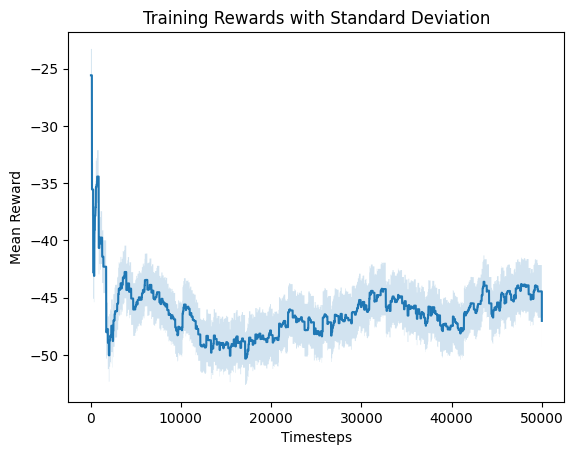

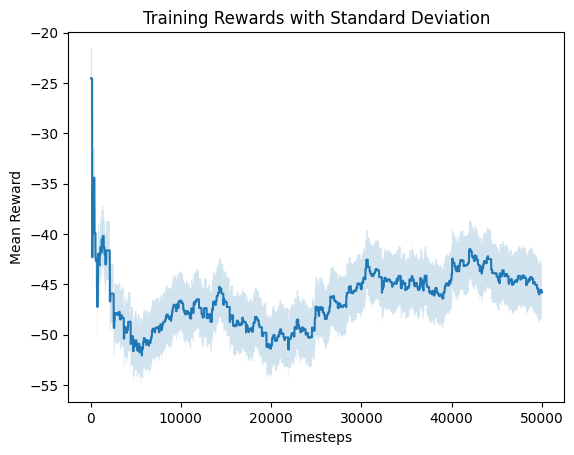

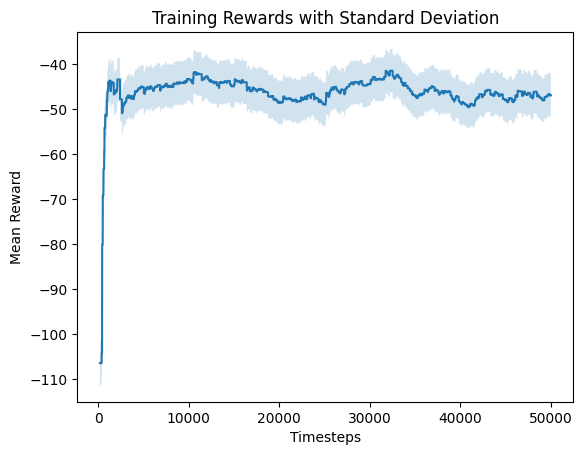

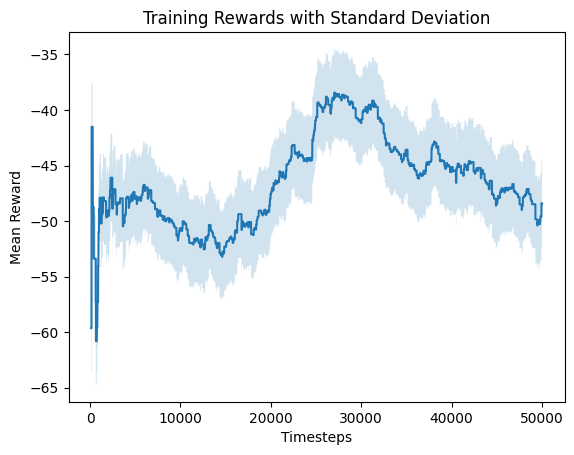

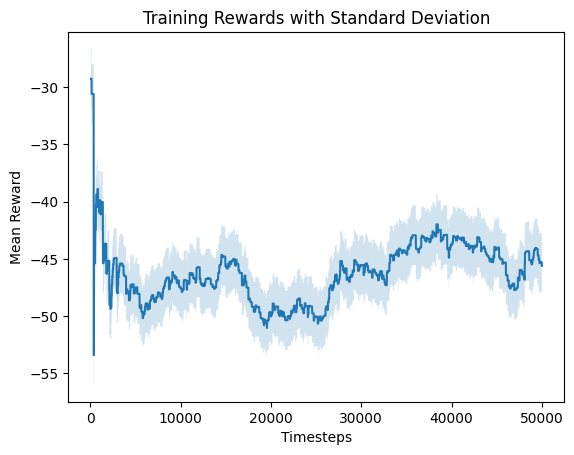

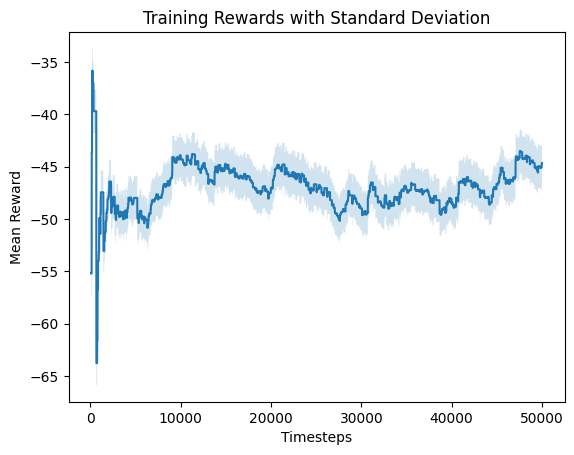

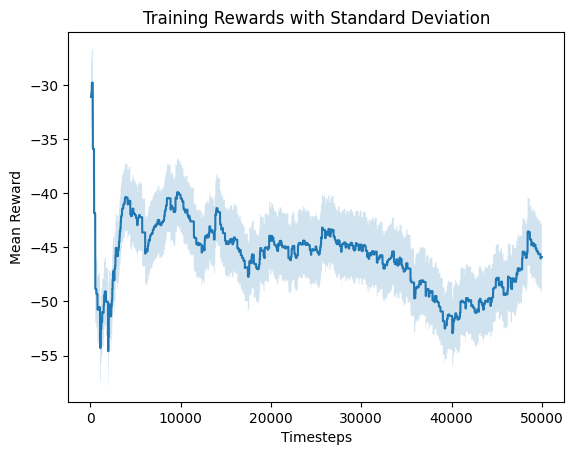

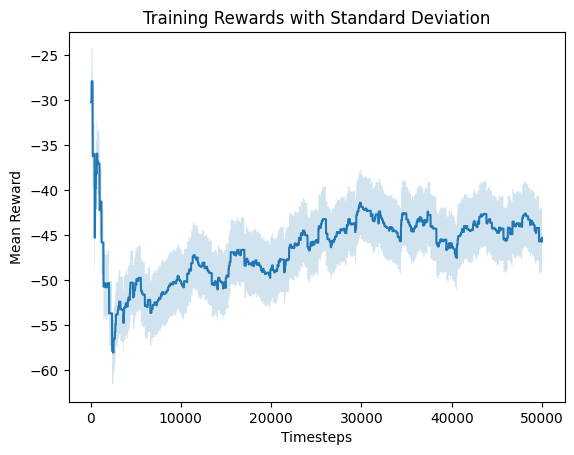

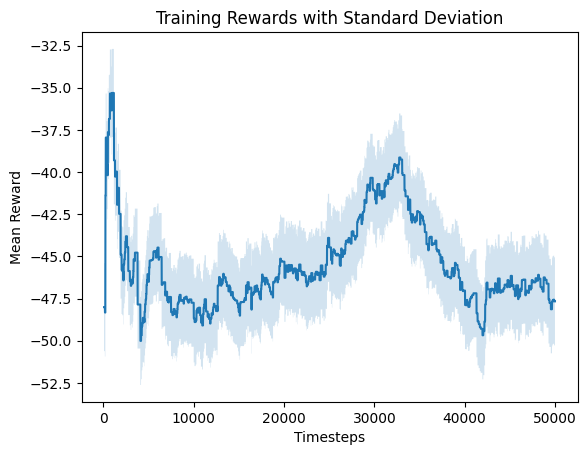

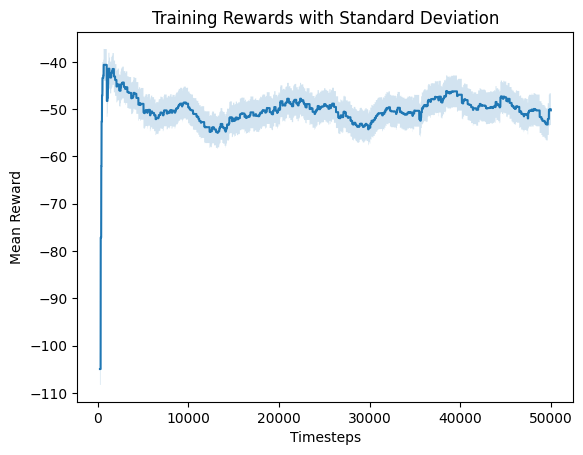

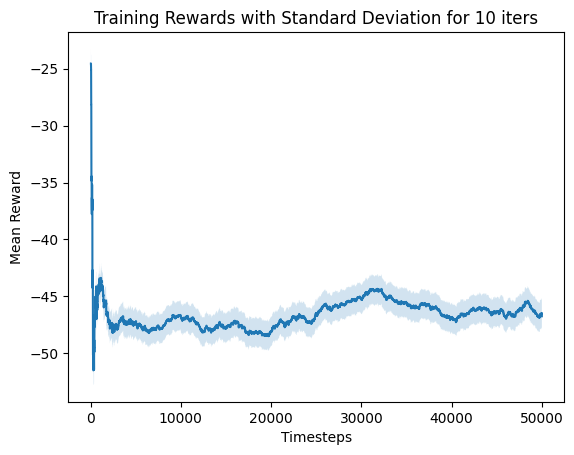

In [ ]:
plot_rews(e1.log_dir)

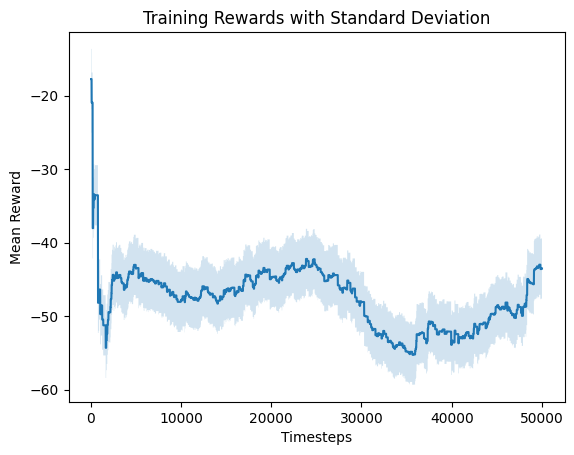

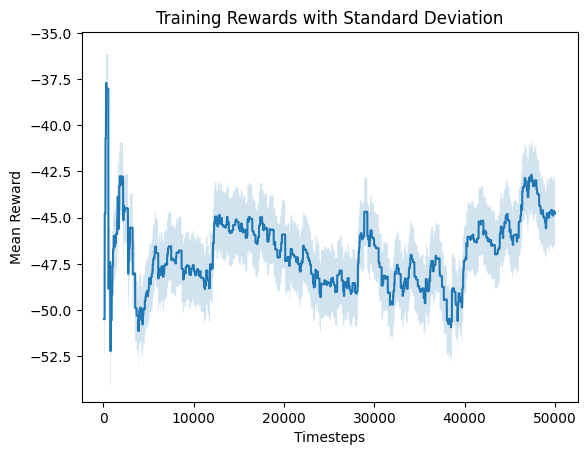

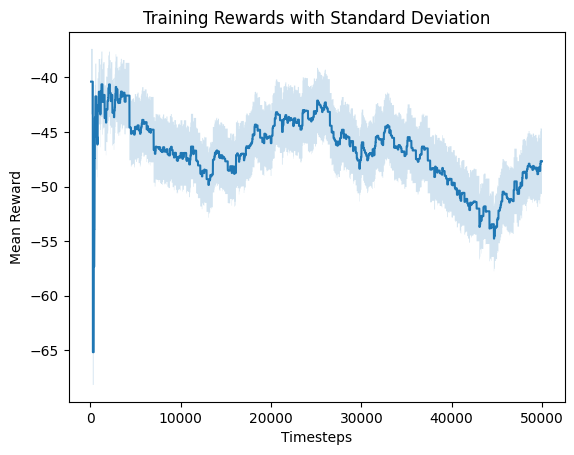

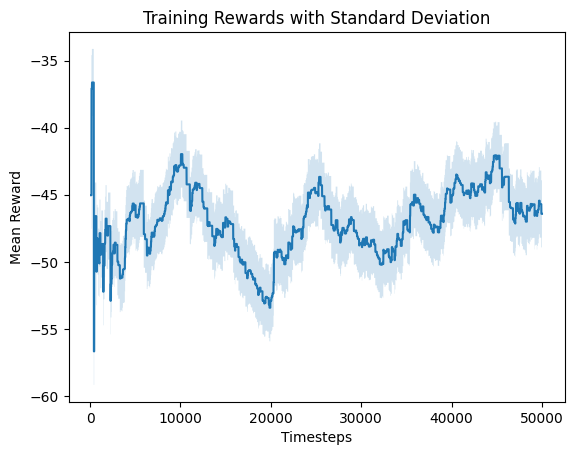

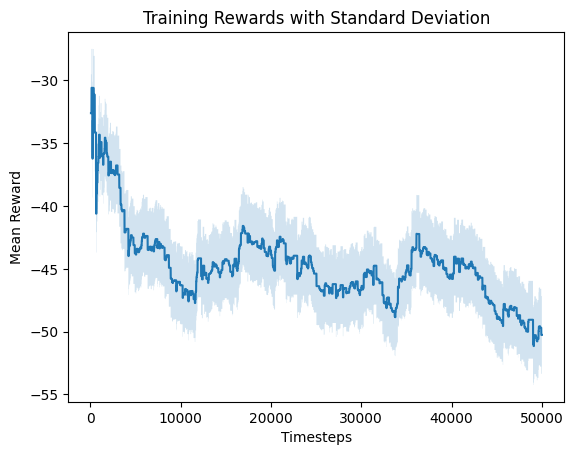

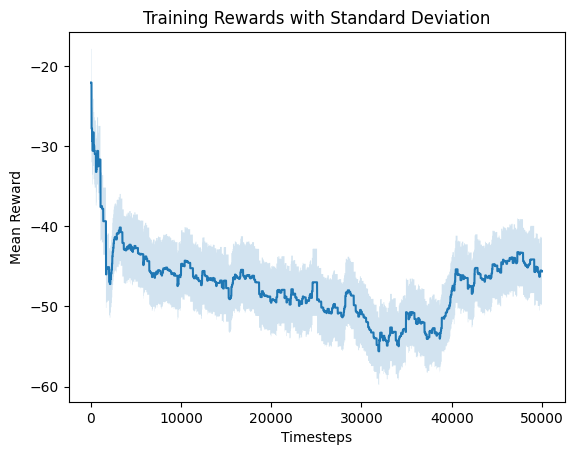

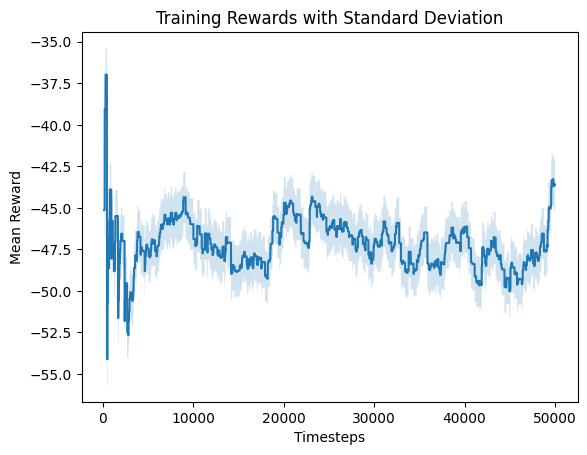

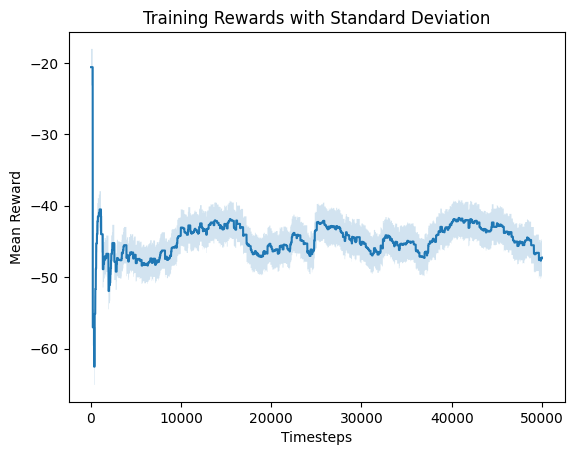

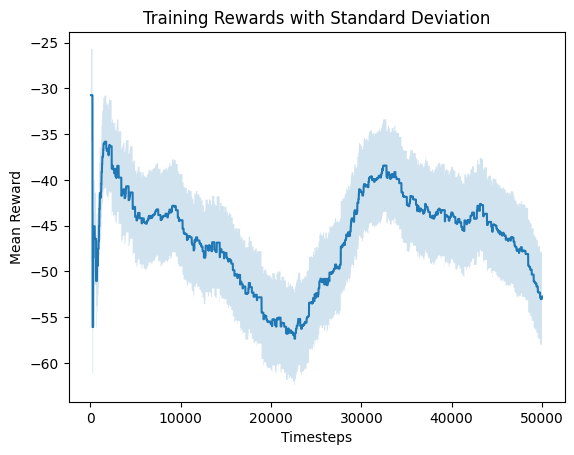

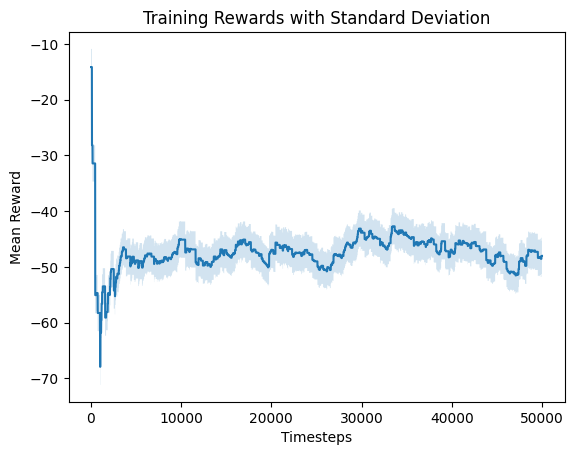

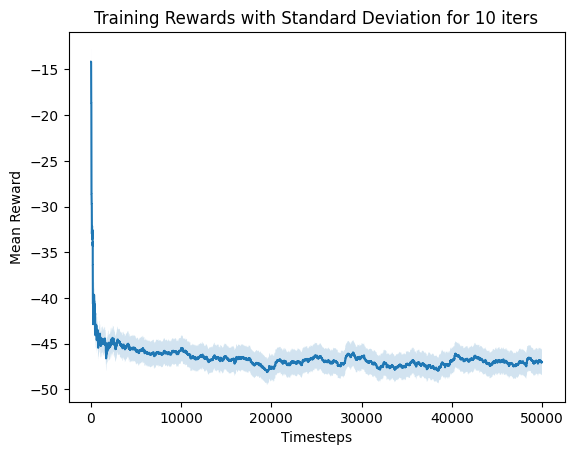

In [ ]:
plot_rews(e2.log_dir)

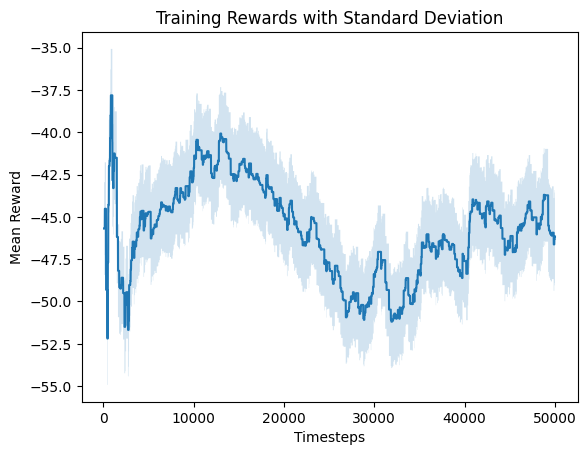

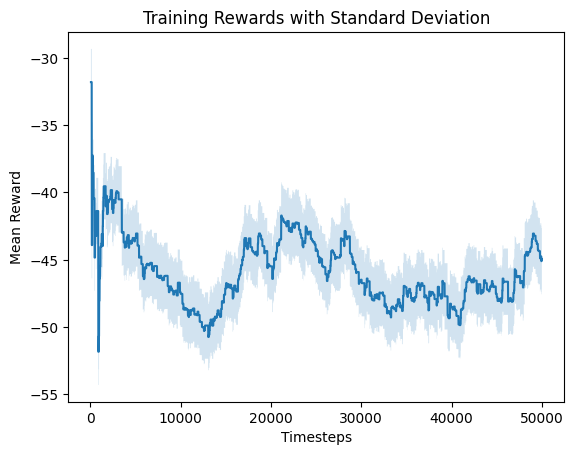

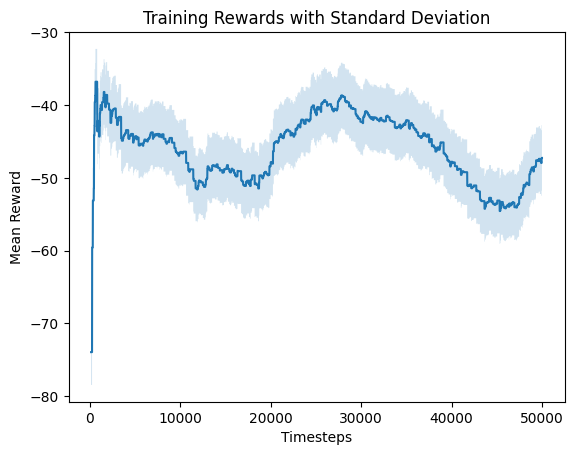

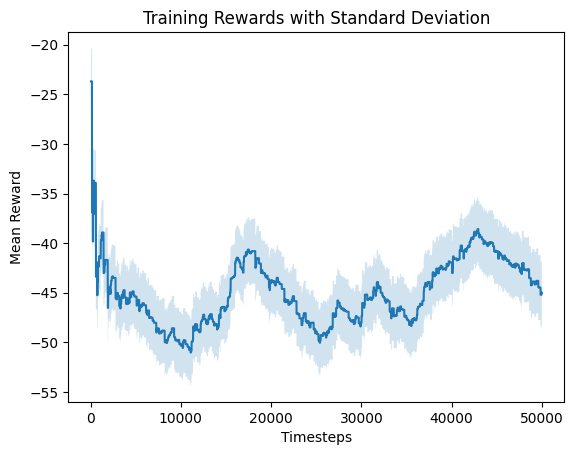

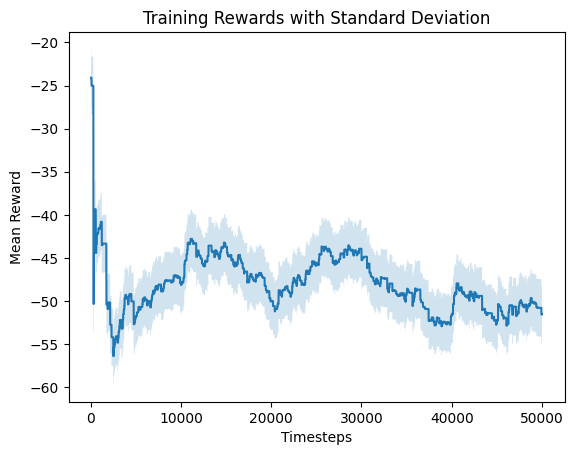

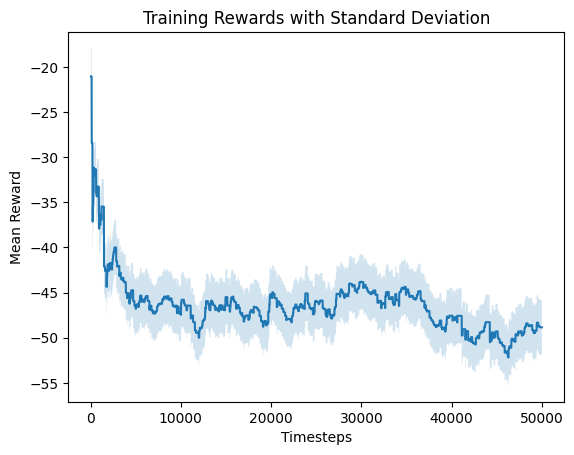

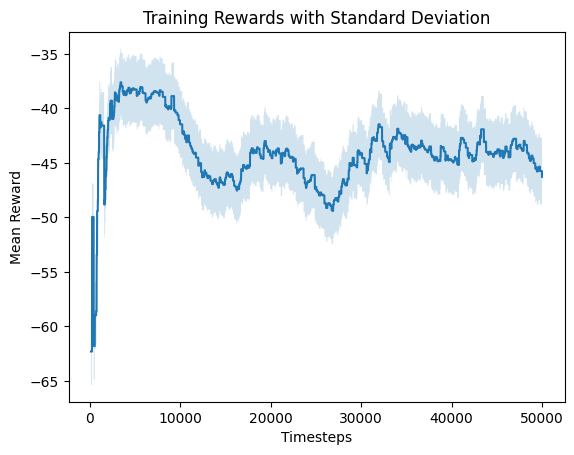

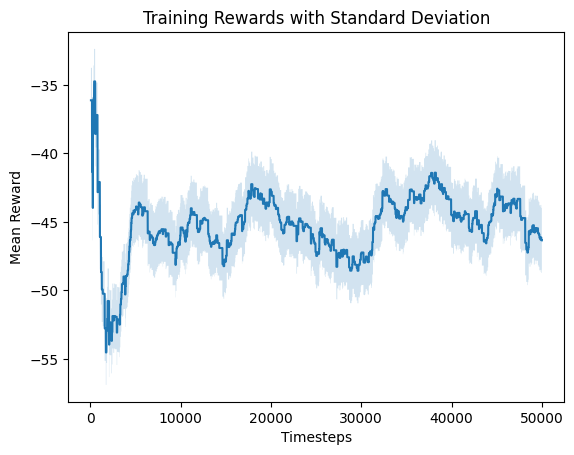

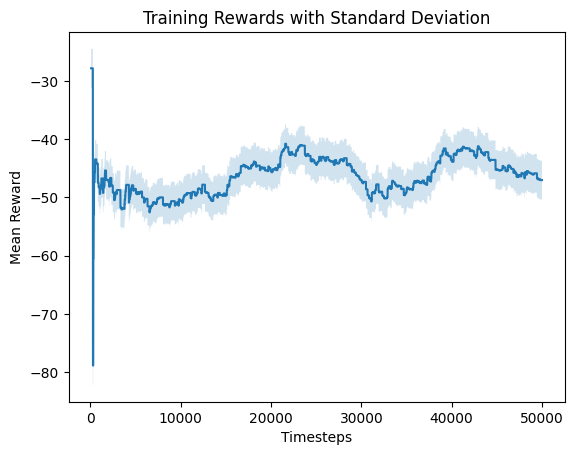

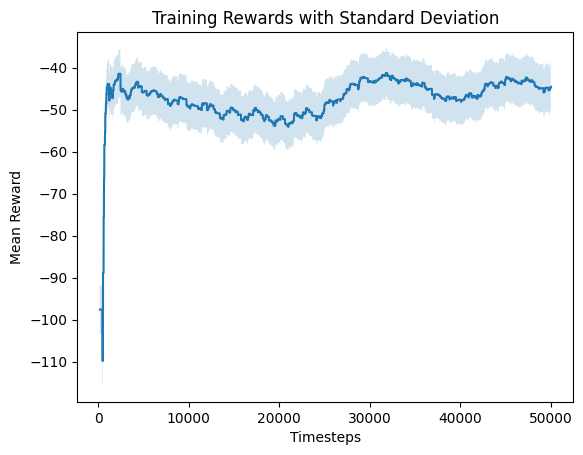

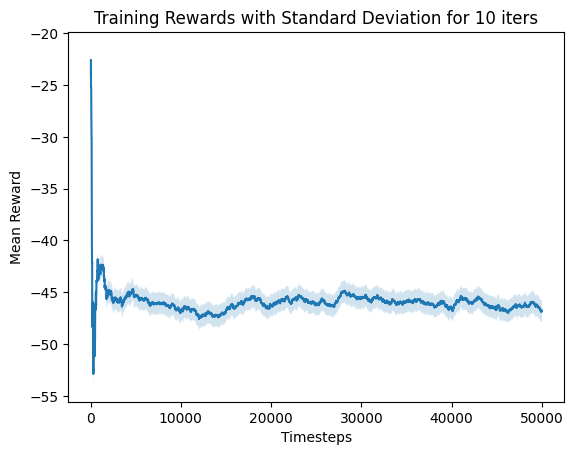

In [ ]:
plot_rews(e3.log_dir)

#Podsumowanie

##Środowisko
W naszym projekcie wykorzystaliśmy środowisko parkingowe z repozytorium highway-env. Środowisko parkowania jest zadaniem ciągłej kontroli uwarunkowanej celem, w którym pojazd musi zaparkować w danym miejscu z odpowiednim kursem.

![parking-env](https://raw.githubusercontent.com/eleurent/highway-env/gh-media/docs/media/parking-env.gif)

##Algorytm uczenia
Trenowanie agenta Soft Actor-Critic (SAC) to algorytm uczenia ze wzmocnieniem dla zadań ciągłej kontroli.

Łączy w sobie sieć aktorów, która uczy się zasad, sieć krytyków, która szacuje funkcję wartości, oraz termin regularyzacji entropii do eksploracji. SAC zbiera dane ze środowiska, aktualizuje krytyka poprzez minimalizację błędu Bellmana, aktualizuje aktora poprzez maksymalizację oczekiwanego zwrotu i dodaje regularyzację entropii, aby zrównoważyć eksplorację i eksploatację. Sieci docelowe są wykorzystywane do stabilizacji treningu. SAC obsługuje ciągłe przestrzenie działań i zachęca do stosowania różnorodnych polityk.

Tutaj używamy strategii próbkowania celu HER "future", w której tworzymy 4 sztuczne przejścia na każde rzeczywiste przejście.

##Czas wykonywania jednego kroku czasowego i epizodu
###Jeden krok czasowy: 0.0216 sek
###Jeden epizod: 1081.1 sek

##Hiperparametry
Żaden z przetestowanych przez nas parametrów nie nauczył się rozwiązywać problemu zadanego przez środowisko. Wszystkie radziły sobie mniej więcej tak samo. Podejrzewamy, że gdybyśmy zwiększyli liczbę kroków, to mógłby się wyłonić jeden, który by ostatecznie rozwiązał problem.
